## Описание набора данных.
Данный набор данных я сделал сам, путем объединения нескольких датасетов скаченных с https://www.kaggle.com. В данном датасете представлены изображения 3 классов мусора: металл, пластик, стекло. Задача обучить модель нейронной сети классифицировать мусор на эти 3 класса.

Импортируем необходимые библиотеки, а также зададим random seed для воспроизводимости результатов

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
tf.random.set_seed(1)

Монтируем google-диск для доступа к датасету

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Mix_dataset_3class.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

Формируем список классов исходя из названий папок в наборе данных

In [ ]:
data_dir  = '/content/dataset/Mix_dataset_3class'
classes = os.listdir(data_dir)
print(classes)

['plastic', 'metal', 'glass']


Смотрим кол-во изображений для каждого класса соответственно металл, стекло, пластик

In [ ]:
quantity = []
for name in classes:
  quantity.append(len(os.listdir(data_dir + '/{}'.format(name))))
print('Металл: ', quantity[0], ' Стекло: ', quantity[1], ' Пластик: ',quantity[2])

Металл:  1347  Стекло:  1179  Пластик:  2512


Учитывая дисбаланс классов создадим дополнительные значения веса классов, для дальнейшего использования их в модели. Это поможет модели "уделять больше внимания" наименее представленным классам, что повышает точность предсказаний.

In [ ]:
class_weights = pd.DataFrame({'Class': classes, 'Quantity': quantity})
class_weights['class_weight'] = class_weights.Quantity.sum() / (class_weights.shape[0] * class_weights.Quantity)
class_weights

,Class,Quantity,class_weight
0,plastic,1347,1.246721
1,metal,1179,1.424371
2,glass,2512,0.668524


In [ ]:
weights = class_weights['class_weight'].to_dict()
weights

{0: 1.2467211086364762, 1: 1.4243709358213175, 2: 0.6685244161358811}

Посмотрим на 5 рандомных изображений с меткой класса.

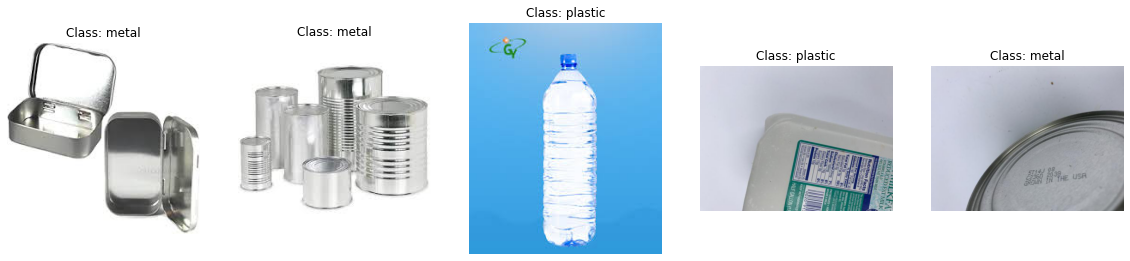

In [ ]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_garbage = random.choice(classes)
    random_image = random.choice(os.listdir(os.path.join(data_dir, random_garbage)))
    random_image_file = os.path.join(data_dir, random_garbage, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Class: " + random_garbage.replace('_', ' '))
    axes[i].axis('off')

plt.show()

Разобъем данные на тренировочные и тестовые на 90% и 10% соответственно.

In [ ]:
import shutil

train_dir = 'train'
test_dir = 'test'

for dir_name in [train_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in classes:
    source_dir = os.path.join(data_dir,  class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(test_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 2512/2512 [00:00<00:00, 10424.06it/s]


Убедимся, что данные разбились и появились тренировочная и тестовая папки, в которых лежат папки с изображениями 3 классов.

In [ ]:
for dir_name in [train_dir, test_dir]:
    for name in classes:
      print(dir_name + ' ' + name + ': ', len(os.listdir(dir_name + '/{}'.format(name))), end= ' ')

train plastic:  1212 train metal:  1061 train glass:  2260 test plastic:  135 test metal:  118 test glass:  252 

Подготовим наши изображения к использованию в нейронной сети.


*   Так как вычислительных мощностей нехватит, чтобы пропустить через нейронную сеть весь датасет, мы разобъем данные на пакеты(батчи). Зададим размер батча = 32 изображения
*   Размер изображения на входе зададим 224х224х3
*   Возьмем 20% данных от тренировочного набора для валидации, это необходимо для оценки процесса обучения модели, так как после пробега модели по валидационной выборке веса модели не изменяеются, т.е. модель на них не тренируется.
*   изменим масштаб значений пикселей входного изображения с помощью rescale, чтобы значения пикселей не были в диапазоне [0,255], а были в диапазоне [0,1], что облегчит работу нейросети
*   Для увеличения выборки в целях борьбы с переобучением модели и повышения точности предсказаний применим аугментацию изображений
*   По итогу было сформировано 113, 28, 15 батча соответственно для тренировочной, валидационной и тестовой выборки.



In [ ]:
batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = len(classes)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=30,
                                   shear_range=0.5,
                                   zoom_range=0.5,
                                   channel_shift_range=50,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(directory='/content/test',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,

                                                    shuffle=True,
                                                    classes=classes
                                                  )

train_generator = train_datagen.flow_from_directory(directory='/content/train',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

valid_generator = train_datagen.flow_from_directory(directory='/content/train',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID, "and", STEP_SIZE_TEST)

Found 505 images belonging to 3 classes.
Found 3627 images belonging to 3 classes.
Found 906 images belonging to 3 classes.
Total number of batches = 113 and 28 and 15


Посмотрим как выглядит рандомное преобразованное изображение.

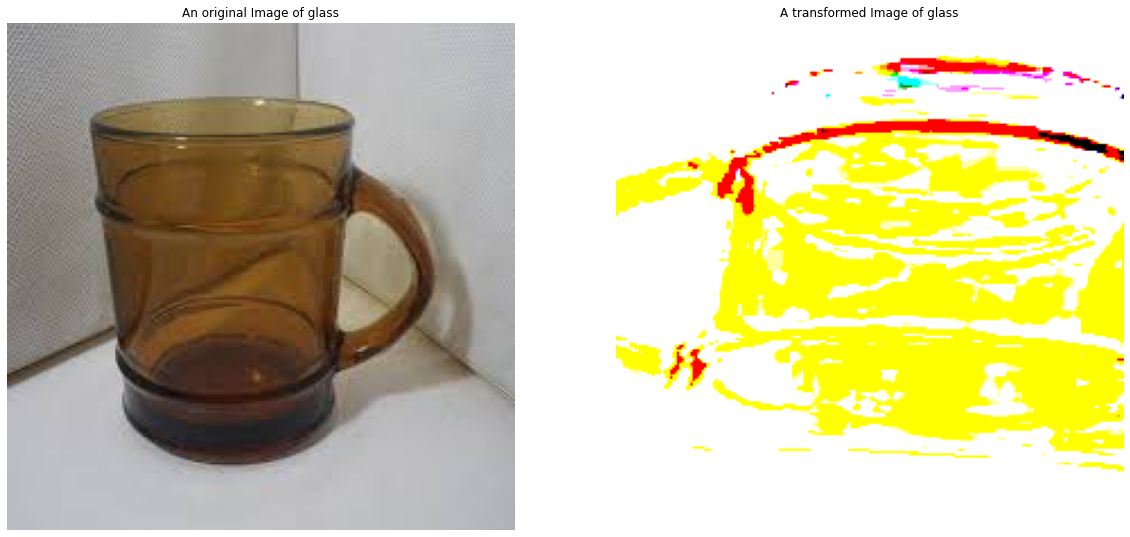

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_garbage = random.choice(classes)
random_image = random.choice(os.listdir(os.path.join('/content/test', random_garbage)))
random_image_file = os.path.join('/content/test', random_garbage, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_garbage.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_garbage.replace('_', ' '))
axes[1].axis('off')

plt.show()

# Постановка задачи и построение модели
Задача - построить и обучить модель нейронной сети классифицировать изображения мусора на 3 класса: металл, стекло, пластик.

Воспользуемся методом передачи знаний transfer learning, т.е. воспользуемся готовой моделью, обученной на датасете imagenet (1000 классов). За основу возьмем модель сверточной нейронной сети ResNet101V2. Веса замораживать не будем, что даст возможность изменяться им в ходе обучения сети.

In [ ]:
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

171317808/171317808 [==============================] - 7s 0us/step


Внесем несколько корректировок в базовую модель для сужения ее специализации под конкретную задачу: растянем последний слой в вектор, добавим полносвязный слой с выходом на 512 нейронов, используем батчнормализацию, функцию активации RElu, затем полносвязный слой с выходом на 16 нейронов, батчнормализацию, функцию активации RElu и финальный полносвязный слой с выходом на 3 нейрона и с функцией активации softmax. Softmax позволяет нам увидеть вероятность принадлежности объекта к конкретному классу.

In [ ]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(classes), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

В качестве метода оптимизации воспользуемся методом градиентного спуска, а именно применим Adam с learning rate = 1-e04; функцией потерь: кросс-энтропия; количество эпох обучения = 60.

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Зададим остановку при отсутствии уменьшения значения функции потерь на валидационной выборке в течение 15 эпох и снижение learning rate при выходе на плато, если в течение 5 эпох значение функции потерь на валидационной выборке не будет изменяеться, то learning rate умножиться на 0.1 .

In [ ]:
n_epoch = 60

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

Запускаем обучение нейронной сети с записью результатов обучения.

In [ ]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=32,
                              class_weight=weights
                             )

<ipython-input-23-f59cb2fe899c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/60
113/113 [==============================] - 117s 806ms/step - loss: 0.6278 - accuracy: 0.7274 - val_loss: 0.4173 - val_accuracy: 0.8393 - lr: 1.0000e-04
Epoch 2/60
113/113 [==============================] - 102s 841ms/step - loss: 0.4132 - accuracy: 0.8592 - val_loss: 0.3795 - val_accuracy: 0.8728 - lr: 1.0000e-04
Epoch 3/60
113/113 [==============================] - 98s 810ms/step - loss: 0.3479 - accuracy: 0.8890 - val_loss: 0.4814 - val_accuracy: 0.8382 - lr: 1.0000e-04
Epoch 4/60
113/113 [==============================] - 95s 790ms/step - loss: 0.3157 - accuracy: 0.9032 - val_loss: 0.4639 - val_accuracy: 0.8225 - lr: 1.0000e-04
Epoch 5/60
113/113 [==============================] - 96s 793ms/step - loss: 0.2828 - accuracy: 0.9138 - val_loss: 0.4419 - val_accuracy: 0.8404 - lr: 1.0000e-04
Epoch 6/60
113/113 [==============================] - 95s 788ms/step - loss: 0.2686 - accuracy: 0.9191 - val_loss: 0.3921 - val_accuracy: 0.8549 - lr: 1.0000e-04
Epoch 7/60
113/113 [======

# Оценка модели и результатов

In [ ]:
history = {}
history['loss'] = history1.history['loss']
history['accuracy'] = history1.history['accuracy']
history['val_loss'] = history1.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy']
history['lr'] = history1.history['lr']

Построим графики процесса обучения сети, отразим на них изменение точности на тренировочной и валидационной выборке с течением эпох. А также изменение функции потерь на тренировочной и валидационной выборке с течением эпох.

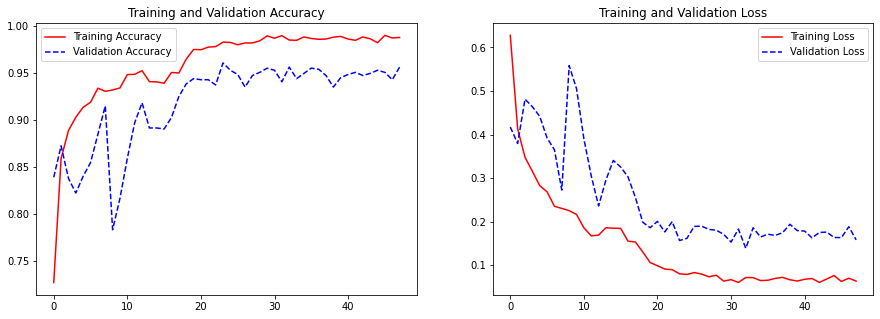

In [ ]:
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(history)

Исходя из графиков можно сделать вывод, что обучение прошло оптимально, эффекта переобучения не наблюдается, так как кривые на двух графиках идут практически параллельно друг другу.

Проверим нашу нейронную сеть на тестовых данных.

In [ ]:
score = model.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on test data =", score[1])

<ipython-input-26-275a058d73eb>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator, verbose=1)


16/16 [==============================] - 4s 213ms/step - loss: 0.1055 - accuracy: 0.9703
Prediction accuracy on test data = 0.9702970385551453


После проверки нашей модели на тестовой выборке, точность (accuracy) составила 0.97. Что можно считать достаточно хорошим показателем.

Построим матрицу ошибок на основе прогона модели на тестовых данных, а также отобразим отчет о классификации. Для этого воспользуемся библиотеками sklearn и seaborn.

1/1 [==============================] - 0s 42ms/step


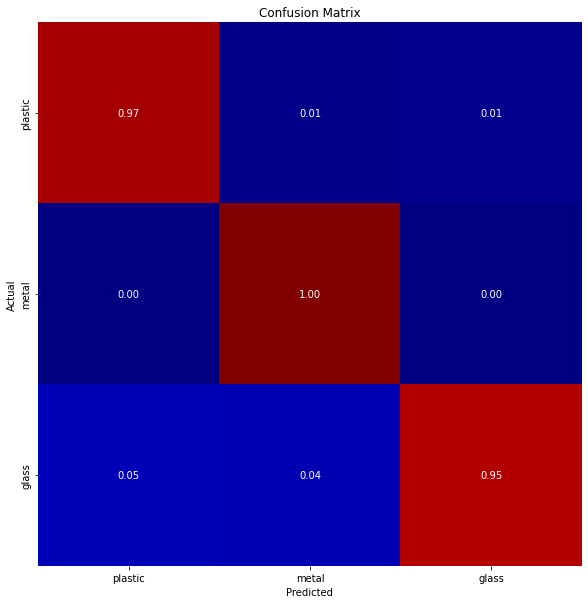

Classification Report:
              precision    recall  f1-score   support

     plastic       0.95      0.97      0.96       126
       metal       0.95      1.00      0.97       112
       glass       0.99      0.95      0.97       242

    accuracy                           0.97       480
   macro avg       0.96      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



In [ ]:
from sklearn.metrics import *
import seaborn as sns

tick_labels = classes

def showClassficationReport_Generator(model, test_generator, STEP_SIZE_TEST):
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_TEST):
        (X,y) = next(test_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes))

showClassficationReport_Generator(model, test_generator, STEP_SIZE_TEST)

Исходя из матрицы неточностей и отчета о классификации можно сказать, что модель достаточно хорошо научилась определять класс мусора, метрика f-мера и полнота данных (recall) получились у всех классов больше 0,95, что говорит о высокой точности искусственной нейронной сети.

Дадим модели предсказать метку класса 5 рандомным изображениям из тестовой выборки и посмотрим на корректность предсказания и на вероятность отношения объекта к предсказанному классу.

1/1 [==============================] - 0s 31ms/step


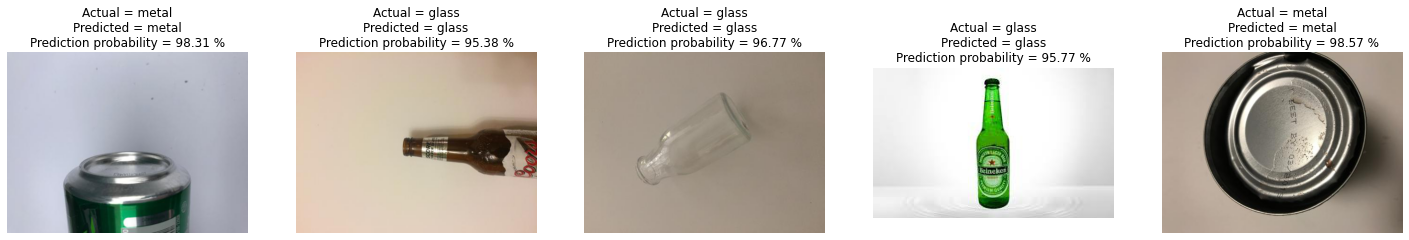

In [ ]:
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_garbage = random.choice(classes)
    random_image = random.choice(os.listdir(os.path.join('/content/test', random_garbage)))
    random_image_file = os.path.join('/content/test', random_garbage, random_image)

    # Original image

    test_image = tf.keras.preprocessing.image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = tf.keras.preprocessing.image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = test_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual = {}\nPredicted = {}\nPrediction probability = {:.2f} %" \
                .format(random_garbage.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

Модель предсказала правильно все 5 изобображений, во всех случаях вероятность отношения к предсказанному класса более 95%, что потдверждает высокую точность модели.

Напишем функцию для возможности классификации изображений из сторонних источников(не из датасета). Для этого воспользуемся библиотеками imageio и cv2

In [ ]:
import imageio
import cv2
def imagefortest(url):
    web_image = imageio.imread(url)
    web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
    web_image = tf.keras.preprocessing.image.img_to_array(web_image)
    web_image /= 255.
    web_image = np.expand_dims(web_image, axis=0)

    prediction = model.predict(web_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    print("Predicted =", labels[prediction_idx].replace('_', ' '))
    print("Prediction probability =", prediction_probability*100, "%")

    plt.imshow(imageio.imread(url))
    plt.axis('off')
    plt.show()


Загрузим изображение, которое было сделано самостоятельно с помощью телефона. Была сфотографирована металлическая консервная банка.

Дадим модели изображение, которое я сделал на свой телефон

1/1 [==============================] - 0s 51ms/step
Predicted = metal
Prediction probability = 97.22137451171875 %


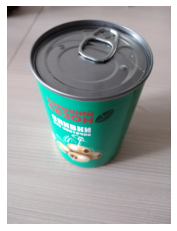

In [ ]:
imagefortest('/content/drive/MyDrive/BTkA52DrZLA.jpg')

Модель прекрасно справилась с данным изображением, верно предсказав класс.

# Вывод:
Таким образом, проведя построение модели искусственной нейронной сети в целях решения задачи компьютерного зрения из разряда классификации, можно сделать вывод, что данная модель благодаря методу передачи знаний (transfer learning), прекрасно справилась с данной задачей и показала хорошие метрики качества. С помощью применения данного метода в совокупности с добавлением дополнительных полносвязных слоев к искусственной нейронной сети ResNet101V2, удалось получить совершенной новую модель, приспособленную решать задачу предсказания класса мусора, а также добиться отличных результатов по метрикам качества оценки модели, выдав точность предсказаний (accuracy) на тестовой выборке равную 0.97, f-меру равную 0,97 и полноту данных (recall) равный 0,97, что говорит о высокой точности прогнозов.